In [ ]:
# ------------------------------------------------------------
# Install lifelines
!pip -q install lifelines

# ------------------------------------------------------------
import os
import random
import copy

import numpy as np
import pandas as pd

from lifelines import CoxPHFitter


# ------------------------------------------------------------
RNG_SEED = 42

def seed_all(seed: int = RNG_SEED) -> None:
    """
    Set random seeds for Python, NumPy, and OS hashing
    to make results reproducible.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

seed_all(RNG_SEED)


# ------------------------------------------------------------
# Load data
Data001 = pd.read_csv(
    "/content/drive/MyDrive/Paper(2025Dec)_SimulatedCVD/Data001_ReadyForCoxPH.csv"
)

# Drop index-like columns if present
for col in ["Unnamed: 0", "index"]:
    if col in Data001.columns:
        Data001 = Data001.drop(columns=[col])

df_raw = copy.copy(Data001)

print("Loaded:", df_raw.shape)
print(df_raw.head())


# ------------------------------------------------------------
# Build design matrix (same as your previous notebooks)
def build_design_matrix(df: pd.DataFrame, drop_cols=None):
    df = df.copy()

    # Center age at 30
    df["Age_c"] = df["Age"] - 30.0

    # IRSD dummies (reference = quintile 5)
    irsd_dummies = pd.get_dummies(
        df["IRSD_quintile"],
        prefix="irsd",
        drop_first=False
    )
    if "irsd_5" in irsd_dummies.columns:
        irsd_dummies = irsd_dummies.drop(columns=["irsd_5"])

    # Smoking dummies (reference = non)
    smoke_dummies = pd.get_dummies(
        df["smoking_status"],
        prefix="smoke",
        drop_first=False
    )
    smoke_dummies = smoke_dummies.fillna(0)
    if "smoke_non" in smoke_dummies.columns:
        smoke_dummies = smoke_dummies.drop(columns=["smoke_non"])

    # Ensure ints where appropriate
    for col in ["AF", "CKD", "diabetes", "cvd_event"]:
        df[col] = df[col].astype(int)

    X = pd.concat(
        [
            df[["Age_c", "AF", "CKD", "diabetes", "HbA1c", "eGFR", "SBP"]],
            smoke_dummies,
            irsd_dummies,
        ],
        axis=1
    )

    # Same "drop near-zero variance" behavior
    cols_to_drop = []
    if drop_cols is None:
        events = df["cvd_event"].astype(bool)

        for col in X.columns:
            v_all      = X[col].var()
            v_event    = X.loc[events, col].var() if events.sum() > 0 else 0.0
            v_nonevent = X.loc[~events, col].var() if (~events).sum() > 0 else 0.0

            if (v_all < 1e-6) or (v_event < 1e-6) or (v_nonevent < 1e-6):
                cols_to_drop.append(col)
    else:
        cols_to_drop = drop_cols

    X_reduced = X.drop(columns=cols_to_drop, errors="ignore")
    return X_reduced, cols_to_drop


# ------------------------------------------------------------
# Assemble full modelling dataframe (use entire dataset)
X_all, cols_to_drop = build_design_matrix(df_raw, drop_cols=None)

cox_all_df = pd.concat(
    [
        df_raw[["cvd_time", "cvd_event"]].reset_index(drop=True),
        X_all.reset_index(drop=True),
    ],
    axis=1
).dropna()

print("Final modelling dataframe shape:", cox_all_df.shape)
print("Dropped columns:", cols_to_drop)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.0/350.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.7 MB/s eta 0:00:00
Loaded: (50000, 12)
   IRSD_quintile        Age smoking_status        BMI  diabetes  CKD  \
0              4  50.395265            non  28.166346         0    0   
1              3  39.226761             ex  16.825992         0    0   
2              5  55.489004            non  23.523419         0    0   
3              4  51.910529            non  31.981932         0    0   
4              1  47.091570             ex  25.351159         0    0   

      HbA1c       eGFR         SBP  AF  cvd_event  cvd_time  
0  4.317890  83.077560  118.668194   0          1  2.963423  
1  4.700951  81.488401  123.719732   0          0  4.407252  
2  3.669685  86.779230  126.650517   0          0  4.490739  
3  4.486977  94.704093  113.889670   0          0  4.888965  
4  4.315440  86.336256  125.912615  

In [ ]:
# ------------------------------------------------------------
# Fit 1) FULL CoxPH model (non-sparse; same penalizer strength)
PENALIZER = 0.01

cph_full = CoxPHFitter(penalizer=PENALIZER, l1_ratio=0.0)
cph_full.fit(
    cox_all_df,
    duration_col="cvd_time",
    event_col="cvd_event",
    show_progress=True,
)

print("\n=== CoxPH (FULL model) fitted on full dataset ===")
cph_full.print_summary()


# ------------------------------------------------------------
# Fit 2) LASSO CoxPH model (sparse; same penalizer strength)
cph_lasso = CoxPHFitter(penalizer=PENALIZER, l1_ratio=0.95)
cph_lasso.fit(
    cox_all_df,
    duration_col="cvd_time",
    event_col="cvd_event",
    show_progress=True,
)

print("\n=== CoxPH (LASSO sparse model) fitted on full dataset ===")
cph_lasso.print_summary()


# ------------------------------------------------------------
# Compare coefficient shrinkage / sparsity
coef_compare = pd.DataFrame({
    "coef_FULL": cph_full.params_,
    "coef_LASSO": cph_lasso.params_,
})

coef_compare["abs_coef_FULL"] = coef_compare["coef_FULL"].abs()
coef_compare["abs_coef_LASSO"] = coef_compare["coef_LASSO"].abs()
coef_compare["LASSO_is_zero"] = np.isclose(coef_compare["coef_LASSO"], 0.0, atol=1e-8)

coef_compare = coef_compare.sort_values("abs_coef_FULL", ascending=False)

Iteration 1: norm_delta = 1.69e+00, step_size = 0.9500, log_lik = -21528.74784, newton_decrement = 5.05e+03, seconds_since_start = 0.9
Iteration 2: norm_delta = 4.68e+00, step_size = 0.9500, log_lik = -22058.07755, newton_decrement = 1.01e+04, seconds_since_start = 1.6
Iteration 3: norm_delta = 1.26e+01, step_size = 0.9500, log_lik = -37014.23881, newton_decrement = 4.34e+04, seconds_since_start = 2.0
Iteration 4: norm_delta = 1.04e+00, step_size = 0.2327, log_lik = -19683.87064, newton_decrement = 1.09e+03, seconds_since_start = 2.4
Iteration 5: norm_delta = 5.58e-01, step_size = 0.2965, log_lik = -19143.73567, newton_decrement = 3.76e+02, seconds_since_start = 2.8
Iteration 6: norm_delta = 2.11e-01, step_size = 0.5011, log_lik = -18866.52901, newton_decrement = 6.78e+01, seconds_since_start = 3.2
Iteration 7: norm_delta = 2.22e-02, step_size = 0.8469, log_lik = -18801.25524, newton_decrement = 1.18e+00, seconds_since_start = 3.6
Iteration 8: norm_delta = 9.67e-05, step_size = 1.0000,

<lifelines.CoxPHFitter: fitted with 50000 total observations, 47991 right-censored observations>
             duration col = 'cvd_time'
                event col = 'cvd_event'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 50000
number of events observed = 2009
   partial log-likelihood = -18800.08
         time fit was run = 2026-02-22 22:30:38 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
Age_c          0.05      1.05      0.00            0.05            0.05                1.05                1.06
AF             1.32      3.76      0.13            1.06            1.58                2.90                4.88
CKD           -0.24      0.79      0.17           -0.57            0.09                0.57                1.10
diabetes       1.64      5.15      0.07            1.50            1.77                4.50                5.88
HbA1c          0.34      1.40      0.02            0.30            0.37                1.35                1.45
eGFR          -0.02      0.98      0.00           -0.03           -0.01                0.97                0.99
SBP            0.01      1.01      0.00            0.01            0.01                1.01                1.01
smoke_current  0.34      1.40      0.06            0.21            0.46                1.24                1.58
smoke_ex       0.28      1.33      0.05            0.18            0.38                1.20                1.47
irsd_1         0.02      1.02      0.05           -0.09            0.12                0.91                1.13
irsd_2         0.09      1.10      0.06           -0.03            0.21                0.98                1.23
irsd_3         0.10      1.11      0.05            0.00            0.21                1.00                1.23
irsd_4         0.01      1.01      0.06           -0.11            0.12                0.89                1.13

               cmp to     z      p  -log2(p)
covariate                                   
Age_c            0.00 28.51 <0.005    591.55
AF               0.00  9.98 <0.005     75.49
CKD              0.00 -1.41   0.16      2.66
diabetes         0.00 24.03 <0.005    421.30
HbA1c            0.00 17.20 <0.005    217.74
eGFR             0.00 -5.23 <0.005     22.53
SBP              0.00  8.90 <0.005     60.67
smoke_current    0.00  5.33 <0.005     23.30
smoke_ex         0.00  5.57 <0.005     25.27
irsd_1           0.00  0.27   0.78      0.35
irsd_2           0.00  1.54   0.12      3.01
irsd_3           0.00  1.97   0.05      4.35
irsd_4           0.00  0.10   0.92      0.12
---
Concordance = 0.87
Partial AIC = 37626.16
log-likelihood ratio test = 5457.34 on 13 df
-log2(p) of ll-ratio test = inf

Iteration 1: norm_delta = 1.79e+00, step_size = 0.9500, log_lik = -28113.64605, newton_decrement = 5.30e+03, seconds_since_start = 0.4
Iteration 2: norm_delta = 1.01e+01, step_size = 0.9500, log_lik = -27323.33986, newton_decrement = 1.89e+04, seconds_since_start = 0.8
Iteration 3: norm_delta = 9.18e+00, step_size = 0.2375, log_lik = -27172.59021, newton_decrement = 2.30e+04, seconds_since_start = 1.2
Iteration 4: norm_delta = 1.24e+00, step_size = 0.0756, log_lik = -23152.21189, newton_decrement = 1.81e+03, seconds_since_start = 1.6
Iteration 5: norm_delta = 8.49e-01, step_size = 0.1278, log_lik = -22088.05567, newton_decrement = 1.06e+03, seconds_since_start = 2.1
Iteration 6: norm_delta = 5.09e-01, step_size = 0.2160, log_lik = -21210.40495, newton_decrement = 4.86e+02, seconds_since_start = 2.8
Iteration 7: norm_delta = 2.84e-01, step_size = 0.3651, log_lik = -20572.45650, newton_decrement = 1.64e+02, seconds_since_start = 3.5
Iteration 8: norm_delta = 1.40e-01, step_size = 0.6170,

<lifelines.CoxPHFitter: fitted with 50000 total observations, 47991 right-censored observations>
             duration col = 'cvd_time'
                event col = 'cvd_event'
                penalizer = 0.01
                 l1 ratio = 0.95
      baseline estimation = breslow
   number of observations = 50000
number of events observed = 2009
   partial log-likelihood = -19425.77
         time fit was run = 2026-02-22 22:30:43 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
Age_c          0.05      1.05      0.00            0.05            0.06                1.05                1.06
AF             0.28      1.33      0.23           -0.16            0.73                0.85                2.07
CKD            0.00      1.00      0.00           -0.00            0.00                1.00                1.00
diabetes       1.80      6.05      0.08            1.65            1.95                5.18                7.05
HbA1c          0.27      1.31      0.02            0.22            0.31                1.25                1.37
eGFR          -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
SBP            0.00      1.00      0.00           -0.00            0.01                1.00                1.01
smoke_current  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
smoke_ex       0.00      1.00      0.00           -0.00            0.00                1.00                1.00
irsd_1         0.00      1.00      0.00           -0.00            0.00                1.00                1.00
irsd_2         0.00      1.00      0.00           -0.00            0.00                1.00                1.00
irsd_3         0.00      1.00      0.00           -0.00            0.00                1.00                1.00
irsd_4        -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

               cmp to     z      p  -log2(p)
covariate                                   
Age_c            0.00 26.53 <0.005    512.86
AF               0.00  1.26   0.21      2.28
CKD              0.00  0.01   1.00      0.01
diabetes         0.00 22.93 <0.005    384.19
HbA1c            0.00 11.64 <0.005    101.60
eGFR             0.00 -0.01   1.00      0.01
SBP              0.00  1.81   0.07      3.83
smoke_current    0.00  0.01   1.00      0.01
smoke_ex         0.00  0.01   1.00      0.01
irsd_1           0.00  0.00   1.00      0.00
irsd_2           0.00  0.00   1.00      0.00
irsd_3           0.00  0.00   1.00      0.00
irsd_4           0.00 -0.00   1.00      0.00
---
Concordance = 0.87
Partial AIC = 38877.54
log-likelihood ratio test = 4205.96 on 13 df
-log2(p) of ll-ratio test = inf

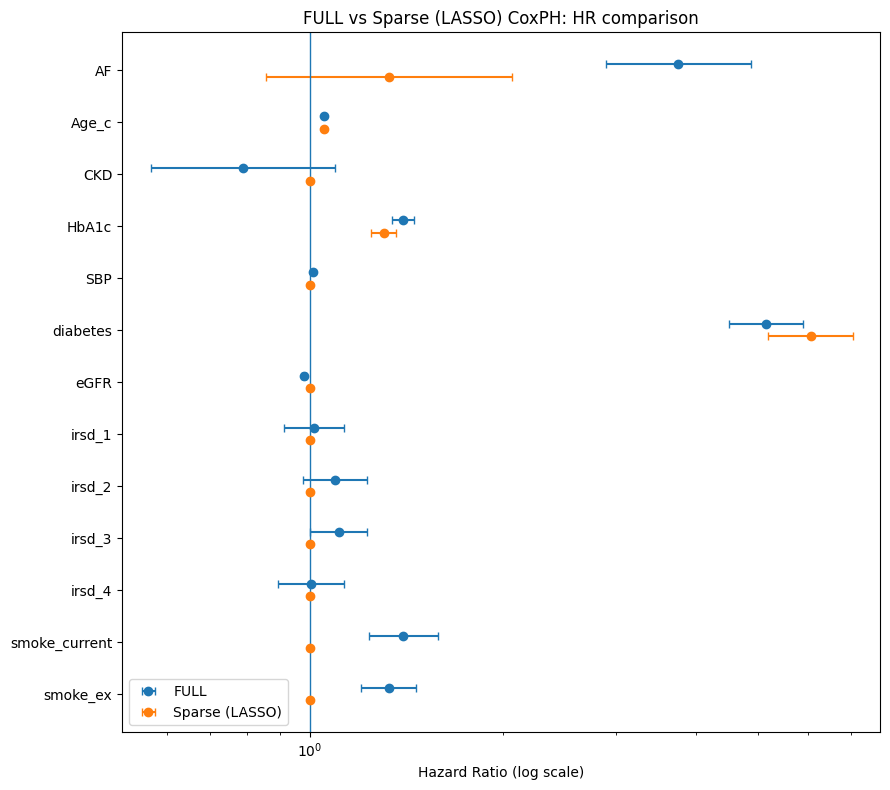

In [ ]:
# ------------------------------------------------------------
# Follow-up: Compare FULL vs LASSO hazard ratios (HRs) visually
# Assumes you already fit:
#   cph_full  (l1_ratio=0.0)
#   cph_lasso (l1_ratio=0.95)
# and created coef_compare as in your snippet.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# Build a tidy comparison table with HR + 95% CI for each model

def extract_hr_ci(cph: CoxPHFitter, model_name: str) -> pd.DataFrame:
    """
    Return a dataframe indexed by covariate name with:
      HR, lower 95% CI, upper 95% CI
    """
    s = cph.summary.copy()

    out = pd.DataFrame({
        "covariate": s.index,
        f"HR_{model_name}": s["exp(coef)"].values,
        f"HRlo_{model_name}": s["exp(coef) lower 95%"].values,
        f"HRhi_{model_name}": s["exp(coef) upper 95%"].values,
    })
    return out.set_index("covariate")


hr_full  = extract_hr_ci(cph_full,  "FULL")
hr_lasso = extract_hr_ci(cph_lasso, "LASSO")

hr_comp = hr_full.join(hr_lasso, how="outer")

# ------------------------------------------------------------
# Plot: side-by-side forest style (FULL vs LASSO)
# Notes:
# - log-scale x-axis (HR)
# - Two points per covariate with horizontal CI bars
# - LASSO non-selected terms typically have HR ~ 1 (coef ~ 0)

def plot_hr_comparison(df: pd.DataFrame, top_n: int = 20):
    d = df.copy().head(top_n)

    # y positions
    y = np.arange(d.shape[0])[::-1]  # top at top

    fig, ax = plt.subplots(figsize=(9, max(5, 0.35 * top_n + 1)))

    # FULL: CI bars + points
    ax.errorbar(
        d["HR_FULL"],
        y + 0.12,
        xerr=[
            d["HR_FULL"] - d["HRlo_FULL"],
            d["HRhi_FULL"] - d["HR_FULL"],
        ],
        fmt="o",
        capsize=3,
        label="FULL",
    )

    # LASSO: CI bars + points
    ax.errorbar(
        d["HR_LASSO"],
        y - 0.12,
        xerr=[
            d["HR_LASSO"] - d["HRlo_LASSO"],
            d["HRhi_LASSO"] - d["HR_LASSO"],
        ],
        fmt="o",
        capsize=3,
        label="Sparse (LASSO)",
    )

    # Reference line at HR=1
    ax.axvline(1.0, linewidth=1)

    # Axis formatting
    ax.set_yticks(y)
    ax.set_yticklabels(d.index.tolist())
    ax.set_xscale("log")
    ax.set_xlabel("Hazard Ratio (log scale)")
    ax.set_title(f"FULL vs Sparse (LASSO) CoxPH: HR comparison")
    ax.legend()

    # Make x-limits reasonable (based on plotted values)
    all_lo = np.nanmin(np.concatenate([d["HRlo_FULL"].values, d["HRlo_LASSO"].values]))
    all_hi = np.nanmax(np.concatenate([d["HRhi_FULL"].values, d["HRhi_LASSO"].values]))
    all_lo = max(all_lo, 1e-3)
    ax.set_xlim(all_lo * 0.9, all_hi * 1.1)

    plt.tight_layout()
    plt.show()

plot_hr_comparison(hr_comp, top_n=20)